# Face Emotion Recognition

# Import Library

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from PIL import Image
import os
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Check GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Import dataset

In [3]:
img_array = cv2.imread('/kaggle/input/emotion-dataset-2/resized-48-48/train/happy/size_48_48_Z (2)_face.png')

Happy image

In [4]:
img_array.shape

(48, 48, 3)

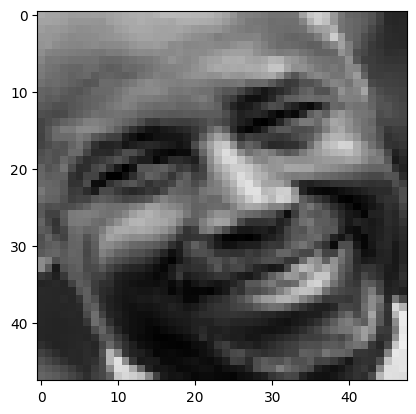

In [5]:
plt.imshow(img_array)

In [6]:
train_dir = "/kaggle/input/emotion-dataset-2/resized-48-48/train/"
test_dir = "/kaggle/input/emotion-dataset-2/resized-48-48/test/"

row, col = 48, 48
classes = 2

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

        sad  happy
train  1067   1266
      sad  happy
test  118    140


Since the model recognize only two emotions either **happy** or **sad**, the classes is equal to 2. 

<AxesSubplot: >

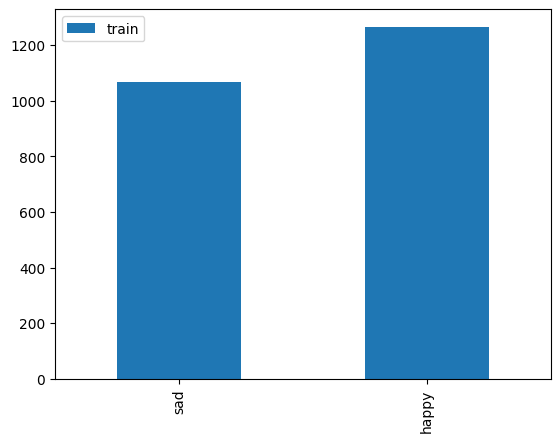

In [7]:
train_count.transpose().plot(kind='bar')

<AxesSubplot: >

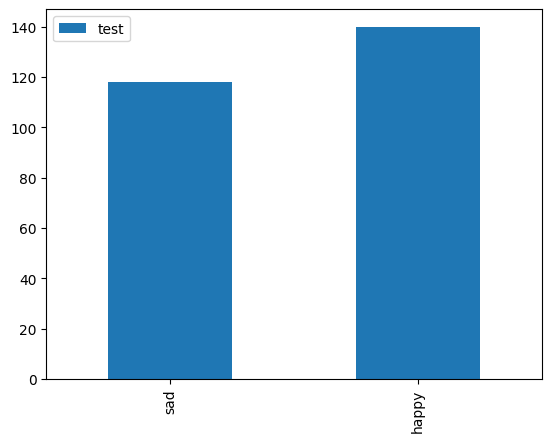

In [8]:
test_count.transpose().plot(kind='bar')

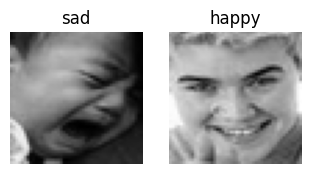

In [9]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# Augmentation

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.4,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=16,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=16,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 2333 images belonging to 2 classes.
Found 258 images belonging to 2 classes.


In [11]:
training_set.class_indices

{'happy': 0, 'sad': 1}

# Creating model

In [12]:
def get_model(input_size, classes=2):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(input_size)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [13]:
print(classes)

2


In [14]:
model_4 = get_model((row,col,1), classes)
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

# Callback

In [15]:
chk_path = 'model_4_v3.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [16]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = model_4.fit(x=training_set,
                 validation_data=test_set,
                 epochs=100,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/100


2023-05-11 08:37:07.550348: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


145/145 [==============================] - ETA: 0s - loss: 3.6331 - accuracy: 0.5585
Epoch 1: val_loss improved from inf to 4.06865, saving model to model_4_v3.h5
145/145 [==============================] - 17s 58ms/step - loss: 3.6331 - accuracy: 0.5585 - val_loss: 4.0687 - val_accuracy: 0.4570 - lr: 1.0000e-04
Epoch 2/100
145/145 [==============================] - ETA: 0s - loss: 3.0793 - accuracy: 0.6047
Epoch 2: val_loss improved from 4.06865 to 4.00291, saving model to model_4_v3.h5
145/145 [==============================] - 4s 30ms/step - loss: 3.0793 - accuracy: 0.6047 - val_loss: 4.0029 - val_accuracy: 0.4609 - lr: 1.0000e-04
Epoch 3/100
145/145 [==============================] - ETA: 0s - loss: 2.9358 - accuracy: 0.6172
Epoch 3: val_loss improved from 4.00291 to 3.59290, saving model to model_4_v3.h5
145/145 [==============================] - 4s 27ms/step - loss: 2.9358 - accuracy: 0.6172 - val_loss: 3.5929 - val_accuracy: 0.4766 - lr: 1.0000e-04
Epoch 4/100
144/145 [==========

### acc: 0.94
### val_acc: 0.88

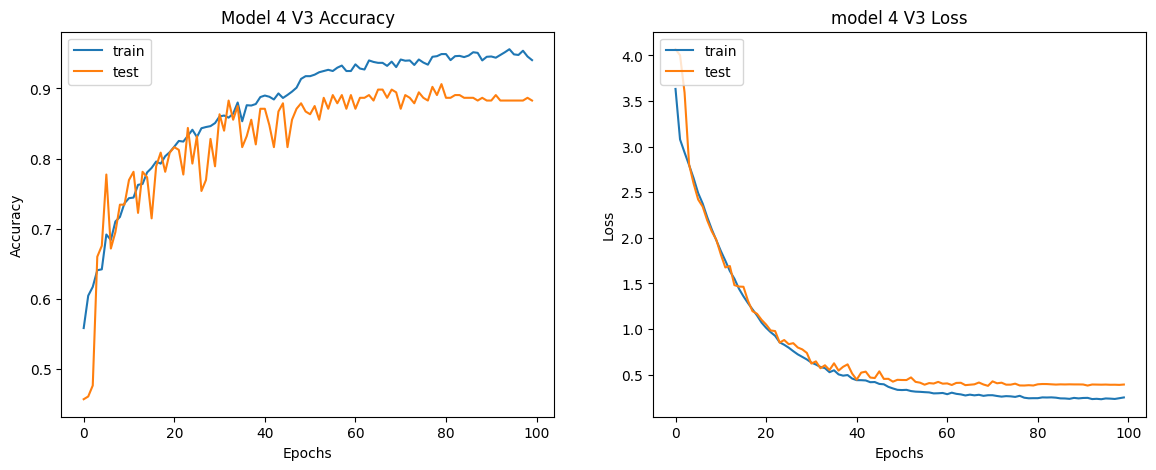

In [17]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model 4 V3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model 4 V3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Evaluation

In [18]:
train_loss, train_accu = model_4.evaluate(training_set)
test_loss, test_accu = model_4.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

17/17 [==============================] - 0s 16ms/step - loss: 0.3896 - accuracy: 0.8837
final train accuracy = 96.83 , validation accuracy = 88.37


In [19]:
model_4.save_weights('model_4_v3_best_weights.h5')

In [20]:
model_4.save('model_4_v3.h5')

# Trying to convert into tflite

In [21]:
import pathlib

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_4)
tflite_model = converter.convert()

In [24]:
tflite_model_file = pathlib.Path('/kaggle/working/model_4_v3.tflite')
tflite_model_file.write_bytes(tflite_model)

33282028